In [1]:
import os
import re
from d2l import torch as d2l
from torch.utils.data import DataLoader,Dataset
import torch
import jieba

# 数据读取

In [2]:
def load_data():
    with open('cmn.txt','r',encoding='UTF-8') as f:
        lines=f.read()
    # 利用正则表达式出去CC-BY开头,换行符结尾的字符
    lines=re.sub(r'CC-BY.*\n','\n',lines)
    return lines
lines=load_data()
print(f'lines.type:{type(lines)}')
print(lines[:500])

lines.type:<class 'str'>
Hi.	嗨。	
Hi.	你好。	
Run.	你用跑的。	
Stop!	住手！	
Wait!	等等！	
Wait!	等一下！	
Begin.	开始！	
Hello!	你好。	
I try.	我试试。	
I won!	我赢了。	
Oh no!	不会吧。	
Cheers!	乾杯!	
Got it?	知道了没有？	
Got it?	懂了吗？	
Got it?	你懂了吗？	
He ran.	他跑了。	
Hop in.	跳进来。	
I know.	我知道。	
I quit.	我退出。	
I quit.	我不干了。	
I'm OK.	我沒事。	
I'm up.	我已经起来了。	
Listen.	听着。	
No way!	不可能！	
No way!	没门！	
Really?	真的？	
Really?	你确定？	
Thanks!	谢谢！	
Try it.	试试吧。	
We try.	我们来试试。	
Why me?	为什么是我？	
Ask Tom.	去问汤姆。	
Awesome!	好棒！	
Be calm.	冷静点。	
Be fair.	公平点。	
Be kind.	友善点。	
Be kind.	友好點。


In [3]:
"""预处理步骤：规范化文本
处理标点符号：标点符号单独加空格分割
处理单词大小写问题：统一转化为小写
处理空格：去除前置和后置空格
"""
def pre_processing(lines):
    """
    lines:str
    return:str
    """
    def no_pre_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    # 大写换小写
    # 去除前置和后置空格|
    lines=lines.replace('\u202f', ' ').replace('\xa0', ' ').lower().strip()
    
    # 标点前加空格
    out=[' '+char if i>0 and no_pre_space(char,lines[i-1]) else char for i,char in enumerate(lines)]
    return ''.join(out)

lines_processed=pre_processing(lines)
print(lines_processed[:200])

hi .	嗨。	
hi .	你好。	
run .	你用跑的。	
stop !	住手！	
wait !	等等！	
wait !	等一下！	
begin .	开始！	
hello !	你好。	
i try .	我试试。	
i won !	我赢了。	
oh no !	不会吧。	
cheers !	乾杯 !	
got it ?	知道了没有？	
got it ?	懂了吗？	
got it ?	你懂了吗？	



# 词元化
注意这里只使用了600个训练样本

In [4]:
"""词元化
按照单词的标准
"""
def tokenize(lines_processed,nums_example=None):
    """
    :param lines_processed: str
    :return: source: list[str]
                target: list[str]
    """
    # 先按照换行符分开，在按照制表符分开
    source=[]
    target=[]
    for i,line in enumerate(lines_processed.split('\n')):
        if nums_example and i > nums_example:
            break
        line=line.strip()# 去除末位多余空格
        
        parts=line.split('\t')
        
        
        if len(parts)==2:
            source.append(parts[0].split(' '))
            # temp=parts[1].replace(' ','')# jieba会把空格当作分词，需要单独处理
            # target.append(list(jieba.cut(temp)))
            target.append(list(jieba.cut(parts[1])))
        
    return source,target


source,target=tokenize(lines_processed,nums_example=600)

print(source[:6])
print(f'source.type:{type(source)}')
print(target[:6])
print(f'target.type:{type(target)}')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ASUS\AppData\Local\Temp\jieba.cache
Loading model cost 0.572 seconds.
Prefix dict has been built successfully.


[['hi', '.'], ['hi', '.'], ['run', '.'], ['stop', '!'], ['wait', '!'], ['wait', '!']]
source.type:<class 'list'>
[['嗨', '。'], ['你好', '。'], ['你', '用', '跑', '的', '。'], ['住手', '！'], ['等等', '！'], ['等', '一下', '！']]
target.type:<class 'list'>


|# 定义Vocab

In [5]:
import collections# 导入统计次数的包
def count_frequency(tokens):
    """
    :param tokens: list[str] or list
    :return: dict{str:int}
    """
    if len(tokens)==0 or isinstance(tokens[0],list):
        tokens=[token for line in tokens for token in line]
    return collections.Counter(tokens)

class Vocab:
        def __init__(self,tokens=None,min_freq=2,reserved_token=None):
            """
            构建token_to_idx,idx_to_token
            :param token: list[str]
            :param min_freq: int
            :param reserved_token:list[str] 
            """
            
            """
            attribute self.min_freq：int
            attribute self.token_freqs：dict {str: int} #注意频率表不包括关键字<unk>,<bos>,<eos>,<pad>
            attribute self.token_to_idx：dict {str: int}
            attribute self.idx_to_token：list[str] #下标代表idx
            """
            # unk词元
            self.unk=0
            
            if tokens is None:
                tokens=[]
            if reserved_token is None:
                reserved_token=[]
            
            # 获取频率表
            counter=count_frequency(tokens)
            self.token_freqs=sorted(counter.items(),key=lambda x:x[1],reverse=True)# 从大到小排序
            self.min_freq=min_freq
            
            # 设置预留词元,unk默认第一位
            self.idx_to_token=['<unk>']+reserved_token
            self.token_to_idx={token:idx for idx,token in enumerate(self.idx_to_token)}
            
            # 开始设置索引
            for token,freq in self.token_freqs:
                if freq<self.min_freq:
                    break
                if token not in self.token_to_idx:
                    self.idx_to_token.append(token)
                    # 注意这里处理的是索引，不是频率
                    self.token_to_idx[token]=len(self.idx_to_token)-1
                    
        def __len__(self):
            return len(self.idx_to_token)
        
        def __getitem__(self,tokens):
            if not isinstance(tokens,(list,tuple)):
                return self.token_to_idx.get(tokens,self.unk)
            return [self.__getitem__(token) for token in tokens]
        
        def to_token(self,indices):
            if not isinstance(indices,(list,tuple)):
                return self.idx_to_token[indices]
            return [self.to_token(index) for index in indices]
        


        def token_freqs(self):
            return self.token_freqs         

In [6]:
def get_max_len(lines):
    # 这个函数不够健全，请确保lines不为空
    """
    :param lines: 已经处理好的list[str]
    :return: max_len: int
    max_len_lines: string
    """
    max_len=-1
    max_len_line=None
    for line in lines:
        temp=len(line)
        if temp>max_len:
            max_len=temp
            max_len_line=line
    return max_len,max_len_line

src_max_len,src_line=get_max_len(source)
tar_max_len,tar_line=get_max_len(target)
print(f'source中最大句子长度为:{src_max_len}\n该句子为：{src_line},\n')
print(f'target中最大句子长度为:{tar_max_len}\n该句子为：{tar_line})\n')

source中最大句子长度为:5
该句子为：['he', 'is', 'a', 'dj', '.'],

target中最大句子长度为:9
该句子为：['你', '就', '随', '了', '我', '的', '意', '吧', '。'])



# 填充或者截断句子
本文不使用max_len作为最大填充(数据量太大)

In [7]:
"""填充"""
def pad_line(line,nums_step,padding_token='<pad>'):
    """
    :param line: 没有转换为索引的token：list[str]
    :param num_steps: 最大时间步：int
    :param padding_token: 填充词，非索引：str
    :return: 填充后的token
    """
    if len(line)>nums_step:
        return line[:nums_step]
    return line+[padding_token]*(nums_step-len(line))


In [8]:
eg_line=['汤姆','不喜欢','你']
eg_line_padded=pad_line(eg_line,tar_max_len)

print(f'填充前的句子：{eg_line}')
print(f'填充后的句子：{eg_line_padded}')

填充前的句子：['汤姆', '不喜欢', '你']
填充后的句子：['汤姆', '不喜欢', '你', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [9]:
"保留字：填充，开头，结尾"
src_vocab=Vocab(source,min_freq=1,reserved_token=['<pad>', '<bos>', '<eos>'])
tar_vocab=Vocab(target,min_freq=1,reserved_token=['<pad>', '<bos>', '<eos>'])

print(f'len of src_vocab.idx_to_token:{len(src_vocab.token_to_idx)}')
for i,(word,freq) in enumerate(src_vocab.token_freqs):
    if i>5:
        print('\n')
        break
    print(f'\'{word} \'出现的频率为:{freq}')

print(f'len of tar_vocab.idx_to_token:{len(tar_vocab.token_to_idx)}')    
for i,(word,freq) in enumerate(tar_vocab.token_freqs):
    if i>5:
        print('\n')
        break
    print(f'\'{word}\'出现的频率为:{freq}')   

len of src_vocab.idx_to_token:414
'. '出现的频率为:462
'i '出现的频率为:106
'! '出现的频率为:78
'? '出现的频率为:62
'i'm '出现的频率为:61
'tom '出现的频率为:45


len of tar_vocab.idx_to_token:564
'。'出现的频率为:456
'我'出现的频率为:173
'了'出现的频率为:114
'！'出现的频率为:75
'？'出现的频率为:56
'是'出现的频率为:46




In [10]:
"""制作为小批量，返回迭代器"""
def package_data(lines,vocab,max_len,device=d2l.try_gpu()): 
    """此函数目的是打包tensor和valid_len
    :param lines: list[str]
    :param vocab: 
    :param num_steps: 
    :param batch_size: 
    :param device: 
    :return::data_iter:tuple(array:tensor:list[str],valid_len:int)
    """
    # 加上终止符
    lines=[line+['<eos>'] for line in lines]

    # 填充
    lines=[pad_line(line,max_len+1) for line in lines]# max_len+1,加上终止符<eos>

    # 转换为索引
    # for i,line in enumerate(lines):
    #     if i<5:
    #         print(line)
    array = torch.tensor([[vocab[token] for token in line ] for line in lines], device=device)
    
    # 返回迭代器
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)# 有效长度：tensor
    
    return array,valid_len
def load_iter(source,src_vocab,src_max_len,target,tar_vocab,tar_max_len,batch_size):
    """
    :param source: 
    :param src_vocab: 
    :param src_len: 最大句子长度
    :param target: 
    :param tar_vocab: 
    :param tar_len: 最大句子长度
    :param batch_size: 
    :return: data_iter:tuple(src_array,src_valid_len,tar_array,tar_valid_len)
    src_vocab,tar_vocab
    """
    src_array,src_valid_len=package_data(source,src_vocab,src_max_len)
    
    tar_array,tar_valid_len=package_data(target,tar_vocab,tar_max_len)
    
    dataset=torch.utils.data.TensorDataset(src_array,src_valid_len,tar_array,tar_valid_len)
    
    data_iter=DataLoader(dataset,batch_size=batch_size,shuffle=True)
    
    return data_iter,src_vocab,tar_vocab

In [11]:
"""测试单元"""
batch_size=2
nums_step=10
"""注意传入src_max_len"""
data_iter,src_vocab,tar_vocab=load_iter(source,src_vocab,nums_step,target,tar_vocab,nums_step,batch_size=batch_size)

for src_array,src_valid_len,tar_array,tar_valid_len in data_iter:
    print(f'src_array:{src_array},src_len:{src_valid_len}')
    print(f'tar_array:{tar_array},tar_len:{tar_valid_len}')
    break

src_array:tensor([[ 20, 239,   4,   3,   1,   1,   1,   1,   1,   1,   1],
        [  8, 112,   4,   3,   1,   1,   1,   1,   1,   1,   1]],
       device='cuda:0'),src_len:tensor([4, 4], device='cuda:0')
tar_array:tensor([[136,  15,   4,   3,   1,   1,   1,   1,   1,   1,   1],
        [  5,   9, 299,  14,   4,   3,   1,   1,   1,   1,   1]],
       device='cuda:0'),tar_len:tensor([4, 6], device='cuda:0')


# EncoderDecoder

In [12]:
import torch
from torch import nn as nn

In [13]:
class EncoderDecoder(nn.Module):
    def __init__(self,encoder,decoder):
        super().__init__()
        self.encoder=encoder
        self.decoder=decoder
        
    def forward(self,enc_X,dec_X):
        """
        :param enc_X: batch_size,num_step 原序列(英文)
        :param dec_X: batch_size,num_step 目标序列(中文)
        :return: batch_size, num_step, vocab_size
        """
        enc_outputs,enc_state=self.encoder(enc_X)
        
        dec_state=self.decoder.init_state(enc_state)
    
        dec_output,dec_state=self.decoder(dec_X,dec_state)

        return dec_output,dec_state

# Encoder for Seq2Seq

In [14]:
class Seq2SeqEncoder(torch.nn.Module):
    def __init__(self,vocab_size,embed_size,hidden_size,num_layers,dropout=0,bidirectional=False):
        super().__init__()
        # 嵌入层
        self.embedding=nn.Embedding(vocab_size,embed_size)
        
        # RNN
        self.rnn=nn.LSTM(embed_size,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True,dropout=dropout)
    def forward(self,enc_X):
        """
        :param: 
        enc_X: batch_size,nums_step
        embedded_X:batch_size,nums_step,embed_size
        :return:
        enc_outputs: batch_size, nums_step, hidden_size
        enc_state:tuple(enc_state,enc_cell) 
        """

        embedded_X=self.embedding(enc_X)
        
        enc_outputs,enc_state=self.rnn(embedded_X)
        
        # enc_state
        return enc_outputs,enc_state

In [15]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, hidden_size=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)#batch_size,nums_step
output, state = encoder(X)
output.shape,state[0].shape,state[1].shape

(torch.Size([4, 7, 16]), torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

# Decoder for Seq2Seq

In [16]:
"""这里与标准代码不同"""
class Seq2SeqDecoder(torch.nn.Module):
    def __init__(self,vocab_size,embed_size,hidden_size,num_layers,dropout=0,bidirectional=False):
        super().__init__()
        # 嵌入层
        self.embedding=nn.Embedding(vocab_size,embed_size)
        
        # RNN:注意在LSTM层拼接上下文向量
        self.rnn=nn.LSTM(embed_size+hidden_size,hidden_size,num_layers=num_layers,bidirectional=bidirectional,dropout=dropout,batch_first=True)
        
        # 线性层
        self.dense=nn.Linear(hidden_size,vocab_size)
        
    def init_state(self,enc_state):
        """
        :param enc_state: 
        :return: 初始状态h_n,c_n
        """
        # 状态取最后一层
        # 记忆细胞不用处理
        
        return enc_state
    
    def forward(self,dec_X,enc_state):
        """
        :param dec_X: 
        embedded_X:batch_size,nums_step,embed_size
        context:batch_size,nums_step,hidden_size 取得是h_n
        X_and_context=batch_size,nums_step,hidden_size+embed_size
        :return: output:batch_size,nums_step,vocab_size
        """
        # 嵌入层

        embedded_X=self.embedding(dec_X)


        # 上下文
        batch_size,nums_step,_=embedded_X.shape

        context=enc_state[0][-1].unsqueeze(1).repeat(1,nums_step,1)
        
        # 拼接上下文
        X_and_context=torch.cat((embedded_X,context),dim=2)
        
        # 输出层
        output,state=self.rnn(X_and_context,enc_state)
        
        output=self.dense(output)
        
        return output,state

In [17]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, hidden_size=16,
                         num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)#batch_size,nums_step

enc_output,enc_state=encoder(X)
print(f'enc_state[0]:{enc_state[0].shape},enc_state[1]:{enc_state[1].shape}')

state=decoder.init_state(enc_state)
print(f'state[0]:{state[0].shape},state[1]:{state[1].shape}')

output,dec_state=decoder(X,state)

print(f'output.shape:{output.shape}')

enc_state[0]:torch.Size([2, 4, 16]),enc_state[1]:torch.Size([2, 4, 16])
state[0]:torch.Size([2, 4, 16]),state[1]:torch.Size([2, 4, 16])
output.shape:torch.Size([4, 7, 10])


# Seq2SeqEncoderDecoder
## 自定义softmax函数

In [18]:
def sequence_mask(X, valid_len, value=0):
    """
    利用广播机制
    :param X: batch_size,nums_step
    :param valid_len: batch_size
    :param value: 0
    :return: 
    """
    max_len=X.shape[1]
    
    mask=torch.arange((max_len), dtype=torch.float32, device=X.device)[None,:]<valid_len[:,None]#1,max_len
    
    # print(f'temp.shape:{temp.shape}')
    # print(temp)
    
    # print(f'value_len.shape:{valid_len.unsqueeze(1).shape}')
    # print(valid_len)
    
    # print(f'mask.shape:{mask.shape}')
    # print(mask)
    
    X[~mask]=value
    
    return X
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [19]:
class MaskedSoftmaxLoss(nn.CrossEntropyLoss):
    """
    pred:batch_size,nums_step,vocab_size
    label:batch_size,nums_step:index
    valid_len:batch_size,int
    """

    def forward(self,pred,label,valid_len):
        # 先把权重变成0-1变量
        weights=torch.ones_like(label)
        weights=sequence_mask(weights,valid_len)
        
        self.reduction='none'# 不进行求和
        
        # 在第二个维度求和，利用广播机制
        unweighted_loss=super(MaskedSoftmaxLoss,self).forward(pred.permute(0,2,1),label)
        
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        
        return weighted_loss
loss = MaskedSoftmaxLoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

# 训练模型

In [20]:
def train_Seq2Seq(net,data_iter,lr,num_epochs,src_vocab,tar_vocab,device=d2l.try_gpu()):
    """序列训练
    tar_vocab:主要是获得<bos>索引
    """
    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m)==nn.LSTM:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
                
        
    # 模型初始化
    net.apply(init_weights)
    
    net.to(device)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    loss=MaskedSoftmaxLoss()
    
    net.train()
    
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer=d2l.Timer()
        
        metric=d2l.Accumulator(2)
        
        for batch in data_iter:
            optimizer.zero_grad()
            
            """
            batch：src_array,src_valid_len,tar_array,tar_valid_len
            array:batch_size,nums_step
            len:batch_size
            bos:batch_size,1
            """
            X_enc,src_valid_len,X_dec,tar_valid_len=[x.to(device) for x in batch]
            
            # <bos>:batch_size,1
            bos = torch.tensor([tar_vocab['<bos>']], device=device).repeat(X_enc.shape[0], 1)
            
            """加上bos，同时保证序列长度不变"""
            dec_input=torch.cat([bos,X_dec[:,:-1]],dim=1)# 拼接bos
            
            y_pred,_=net(X_enc,dec_input)
            
            l=loss(y_pred,X_dec,tar_valid_len)
            
            l.sum().backward()
            
            # 梯度裁剪
            d2l.grad_clipping(net,1)
            
            num_tokens=tar_valid_len.sum()
            
            optimizer.step()
            
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
                
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
            
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')
        

loss 0.011, 15177.5 tokens/sec on cuda:0


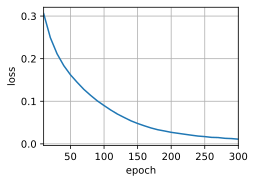

In [21]:
embed_size,hidden_size,num_layer,dropout=32,32,2,0.1
nums_step=10
batch_size=64
lr,nums_epoch,device=5e-3,300,d2l.try_gpu()
data_iter,src_vocab,tar_vocab=load_iter(source, src_vocab, nums_step, target, tar_vocab, nums_step, batch_size)

"""
class Seq2SeqEncoder(torch.nn.Module):
    def __init__(self,vocab_size,embed_size,hidden_size,num_layers,dropout=0.1,bidirectional=False):
class Seq2SeqDecoder(torch.nn.Module):
    def __init__(self,vocab_size,embed_size,hidden_size,num_layers,dropout=0.1,bidirectional=False):
"""
train_encoder=Seq2SeqEncoder(len(src_vocab),embed_size,hidden_size,num_layer,dropout=dropout,bidirectional=False)
train_decoder=Seq2SeqDecoder(len(tar_vocab),embed_size,hidden_size,num_layer,dropout=dropout,bidirectional=False)
train_edcoder=EncoderDecoder(train_encoder,train_decoder)

train_Seq2Seq(train_edcoder,data_iter,lr,nums_epoch,src_vocab,tar_vocab,device)

# Seq2Seq预测

In [22]:
# 测试nn预处理函数
def tokenize_single(src_processed):
    
    src_tokens=src_processed.split(' ')
    
    return src_tokens

src_sentence='I won!'

src_processed=pre_processing(src_sentence)

print(f'src_processed: {src_processed}')

src_tokens=tokenize_single(src_processed)
    
print(f'src_token:{src_tokens}')

src_padded=pad_line(src_tokens,nums_step)

print(f'src_padded: {src_padded}')
print(f'src_len:{len(src_padded)}')

print(f'src_padded of vocab:{src_vocab[src_padded]}')

src_processed: i won !
src_token:['i', 'won', '!']
src_padded: ['i', 'won', '!', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
src_len:10
src_padded of vocab:[5, 48, 6, 1, 1, 1, 1, 1, 1, 1]


In [23]:
def predict_Seq2Seq(net,src_tokens,src_vocab,tar_vocab,max_steps,device=d2l.try_gpu()):
    """
    param:src_sentence:list[str]
    :return: 
    """
    
    """
    procedure:
    1.对source_sentence进行预处理：分词+空格+填充+索引
    2.encoder获取context
    3.decoder自回归
    """
    
    """Data process"""
    net.eval()
    
    src_tokens=src_tokens+['<eos>']# 可以没有bos，但是必须要有eos
    
    enc_valid_len = torch.tensor([len(src_tokens)], device=device) # 可能会有用
    
    src_tokens=pad_line(src_tokens,max_steps)
    
    src_tokens=src_vocab[src_tokens] # nums_step(index)
    
    """get context"""
    X_enc=torch.unsqueeze(torch.tensor(src_tokens,dtype=torch.long,device=device),dim=0)# batch_size,nums_step
    enc_output,enc_state=net.encoder(X_enc)# batch_size,nums_step,hidden_size
    
    dec_state=net.decoder.init_state(enc_state)
    
    """decoder自回归过程"""
    X_dec=torch.unsqueeze(torch.tensor([tar_vocab['<bos>']],dtype=torch.long,device=device),dim=0)# 初始化输入<'bos'>
    # X_dec:batch_size=1,nums_step=1
    
    output_Seq=[]
    for i in range(max_steps):
        Y,dec_state=net.decoder(X_dec,dec_state)# 1,nums_step,vocab_size
        
        X_dec=Y.argmax(dim=2)# 取极大值
        
        pred=X_dec.squeeze(dim=0).type(torch.int32).item()# nums_step
                
        if pred==tar_vocab['<eos>']:
            break
        
        output_Seq.append(pred)
    str_Seq=' '.join(tar_vocab.to_token(output_Seq))
    return output_Seq,str_Seq

# 模型评估

In [24]:
"""中文预测"""

engs =source[:40]
chs = target[:40]
for eng, ch in zip(engs, chs):
    ch_seq,ch_str= predict_Seq2Seq(
        train_edcoder, eng, src_vocab, tar_vocab, nums_step, device)
    
    tar_sentence=' '.join(eng)
    translation= ch_str.replace(' ','')# 清楚无效空格
    
    print(f'{tar_sentence} => {translation}')

hi . => 嗨。
hi . => 嗨。
run . => 你用跑。
stop ! => 住手！
wait ! => 等等！
wait ! => 等等！
begin . => 开始！
hello ! => 你好。
i try . => 我试试。
i won ! => 我赢了。
oh no ! => 不会吧。
cheers ! => 乾杯!
got it ? => 懂了吗？
got it ? => 懂了吗？
got it ? => 懂了吗？
he ran . => 他跑了。
hop in . => 跳进来。
i know . => 我知道。
i quit . => 我不。
i quit . => 我不。
i'm ok . => 我沒事。
i'm up . => 我吃飽了。
listen . => 听着。
no way ! => 没门！
no way ! => 没门！
really ? => 真的？
really ? => 真的？
thanks ! => 谢谢！
try it . => 试试吧。
we try . => 我们来。
why me ? => 为什么是我？
ask tom . => 去问汤姆。
awesome ! => 好棒！
be calm . => 冷静点。
be fair . => 请用座。
be kind . => 友好點。
be kind . => 友好點。
be nice . => 友善点。
be nice . => 友善点。
call me . => 联系我。
